# Description

Copied below is the introductory text for the project

#### Context:
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalised campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the bank poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

### Objective:
**To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.**

#### Dataset:  ALLLife bank
**Data Description:** Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online and through a call centre.  

#### Key Questions:
* Perform EDA.
* Apply Clustering Algorithms and mentions how many clusters are formed ?
* How are these segments different from each other?
* What are your recommendations to the bank on how to better market to and service these customers?


### Further Comments on Problem and Data Set
The objective is to "identify different segments in the existing customers based on their spending patterns as well as past interaction with the bank." In our data we have 5 variables (that are not simply customer numbers or index numbers). They are:
  
**Data Describing Spending Habits:**
* Avg_Credit_Limit: customer credit limit.
* Total_Credit_Cards: the total number of credit cards the customer has.

The description does not specify if the number of credit cards the customer has is with the bank, or in general. It doesn't really make sense for a customer to have multiple credit cards with the same institution. Usually people get credit cards with different banks/merchants in order to maximize rewards.

**Channels through which customer has contacted the bank for any queries**
* Total_visits_bank: number of in-person visits by customer.
* Total_visits_online: number of times customer has contacted the bank online.
* Total_calls_made: number of times the customer has contacted the bank by calling the bank's call centre.

We can segment the customers using various unsupervised learning clustering techniques. That part is straightforward.  
The bank also wants to "upgrade the service delivery model, to ensure that customers queries are resolved faster". However as we have no data telling us how long a given query took to resolve or how satisfied a customer was with their service, this part of the question is much harder to answer. Let's dig into the data and see what is revealed.


In [178]:
# Library to suppress warnings or deprecation notes 
import warnings
warnings.filterwarnings('ignore')


# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

# Libraries to help with data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True) #to make things look a little prettier

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist, pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# Initial Data Read and First Look

In [179]:
# Load data from xlsx file
Credit_df = pd.read_excel('Credit Card Customer Data.xlsx')
Credit_df # look at head and tail of data

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3
...,...,...,...,...,...,...,...
655,656,51108,99000,10,1,10,0
656,657,60732,84000,10,1,13,2
657,658,53834,145000,8,1,9,1
658,659,80655,172000,10,1,15,0


* We have 660 rows and 7 columns.
* As per the project FAQ: The 'Customer Key' is a unique ID given to each customer in the database, and can be ignored during the analysis. We will drop this column.
* Sl_No is obviously an index number and does not contain information we need for clustering, so we will also drop SI_No.  

Before we drop rows, let's check to make sure that these values are serial numbers and that there no duplicates

### Duplicate Observations
Note: There was a lot more work with duplicates than I expected, so I have given this section its own subheading

In [180]:
Credit_df['Sl_No'].duplicated().value_counts() # check for duplicates in Sl_No, there are none.

False    660
Name: Sl_No, dtype: int64

There are no duplicates in the SI_No column. Every value is unique and we can safely drop this column as it is simply an index.

In [181]:
Credit_df['Customer Key'].duplicated().value_counts() # check for duplicates in Customer Key.

False    655
True       5
Name: Customer Key, dtype: int64

* It appears that there are 5 times in the data where the customer key has been duplicated, let's investigate:

In [182]:
Credit_df[Credit_df['Customer Key'].duplicated()]

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
332,333,47437,17000,7,3,1,0
398,399,96929,67000,6,2,2,2
432,433,37252,59000,6,2,1,2
541,542,50706,60000,7,5,2,2
632,633,97935,187000,7,1,7,0


* The table above shows the duplicated customer keys. Let's look at one of these values in more detail:

In [183]:
Credit_df[Credit_df['Customer Key']==47437]

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
4,5,47437,100000,6,0,12,3
332,333,47437,17000,7,3,1,0


* Here we can see that the customer key has been duplicated but the customer details are different! We expect a Customer Key to be a unique value assigned to each customer. This could be a type let's check the other values to find out:

In [184]:
Credit_df[Credit_df['Customer Key']==96929]

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
391,392,96929,13000,4,5,0,0
398,399,96929,67000,6,2,2,2


In [185]:
Credit_df[Credit_df['Customer Key']==37252]

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
48,49,37252,6000,4,0,2,8
432,433,37252,59000,6,2,1,2


In [186]:
Credit_df[Credit_df['Customer Key']==50706]

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
411,412,50706,44000,4,5,0,2
541,542,50706,60000,7,5,2,2


In [187]:
Credit_df[Credit_df['Customer Key']==97935]

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
104,105,97935,17000,2,1,2,10
632,633,97935,187000,7,1,7,0


* In ALL cases where the Customer Key has been duplicated, the customer details are not the same. This does not meet our expectations of a customer key! 
* Given that the Customer Key does not function correctly as a customer key NOR does it provide any useful information, we can safely drop this column.

In [188]:
df = Credit_df.copy() # Copy origianl data frame to keep original intact
df.drop(columns=['Sl_No', 'Customer Key'], axis=1, inplace=True) # drop columns
df # look at head and tail of working data set

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3
...,...,...,...,...,...
655,99000,10,1,10,0
656,84000,10,1,13,2
657,145000,8,1,9,1
658,172000,10,1,15,0


* After dropping columns, the number of columns in our working data frame is 5.

In [189]:
df.duplicated().value_counts()

False    649
True      11
dtype: int64

* There are still 11 duplicates in our data. Given that there are only 5 variables and 660 rows. It's not completely unreasonable to believe that there could be customers who have exactly the same behavior. Let's take a closer look:

In [190]:
df[df.duplicated()]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
162,8000,2,0,3,4
175,6000,1,0,2,5
215,8000,4,0,4,7
295,10000,6,4,2,3
324,9000,4,5,0,4
361,18000,6,3,1,4
378,12000,6,5,2,1
385,8000,7,4,2,0
395,5000,4,5,0,1
455,47000,6,2,0,4


* There is no particular pattern to the duplicated rows. However the duplicated points will not add information to our clusters, so we can safely drop these points.

In [191]:
df.drop_duplicates(inplace=True) # drop duplicated rows

### Data Statistics
Now that we have dropped two columns that were not contributing to our interpretation and duplicate rows, let's continue exploring the data.

In [192]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 649 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     649 non-null    int64
 1   Total_Credit_Cards   649 non-null    int64
 2   Total_visits_bank    649 non-null    int64
 3   Total_visits_online  649 non-null    int64
 4   Total_calls_made     649 non-null    int64
dtypes: int64(5)
memory usage: 30.4 KB


* After dropping duplicates, our number of rows has dropped by 11 from 660 to 649. Our number of columns after dropping Sl_No and Customer Key is 5.
* All of our column data are numerical, so we will not need to do any encoding of variables before running our clustering. Furthermore, all data types are int64, so all data are integers (i.e. whole numbers, no fractions).
* We can see that there are no null values in our 660 rows of data. Given that all data points are numerical, there are also no strange characters that we will need to look our for.

In [193]:
df.isna().sum() # confirm that there are no null values.

Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [194]:
df.describe().T # let's look at some stats

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,649.0,34878.274268,37813.736638,3000.0,11000.0,18000.0,49000.0,200000.0
Total_Credit_Cards,649.0,4.708783,2.173763,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,649.0,2.397535,1.625148,0.0,1.0,2.0,4.0,5.0
Total_visits_online,649.0,2.624037,2.952888,0.0,1.0,2.0,4.0,15.0
Total_calls_made,649.0,3.590139,2.877911,0.0,1.0,3.0,5.0,10.0


* Avg_Credit_Limit is right skewed; we can see that the mean and median are quite different. The maximum value is also quite a distance from the 75% value.
* Total_Credit_Cards and Total_visits_bank appear to be fairly normally distributed.
* Total_vistis_online appears to have at least one outlier on the high side: Max value is 15, while 75% value is only 4.
* Total_calls_made also appears to have outliers: max value is double the 75% value. This is likely why the mean and median do not align (i.e. outliers have shifted the mean).
* There are zero values in the 3 of the columns describing how a customer contacts the bank, however it is possible that a customer has not contacted the bank, meaning that the zeros are likely real values and not an indication of missing values.
* The mean and median value for Total_calls_made is higher than for Total_visits_online and Total_visits_bank. This means that more customers are calling the bank than any other form of contact.

# EDA - Univariate Analysis

We will define two functions to help us understand the distribution of each variable. The first function plots both a boxplot and histogram. For variables with a large range it makes sense to plot them using these display tools.  
For the other variables, we will plot the box plot and histogram, however, we will also plot count plots with the percentages shown on the graph. Given that the range of these variables is very small and all values are integers, it makes sense to visualize them as if they were categorical variables.

In [195]:
# function to plot a boxplot and a histogram along the same scale.
def histogram_boxplot(data, feature, figsize=(10, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [196]:
# Write some code to plot categorical variables with the percentage on the bar.
def perc_on_bar(feature):
    """
    plot
    feature: categorical feature
    the function won't work if a column is passed in the hue parameter
    """
    # Creating a countplot for the feature
    sns.set(rc={"figure.figsize": (10, 5)})
    ax = sns.countplot(x=feature, data=df)

    total = len(feature)  # length of the column
    for p in ax.patches:
        percentage = "{:.1f}%".format(
            100 * p.get_height() / total
        )  # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.1  # width of the plot
        y = p.get_y() + p.get_height()  # hieght of the plot
        ax.annotate(percentage, (x, y), size=14)  # annotate the percantage

    plt.show()  # show the plot

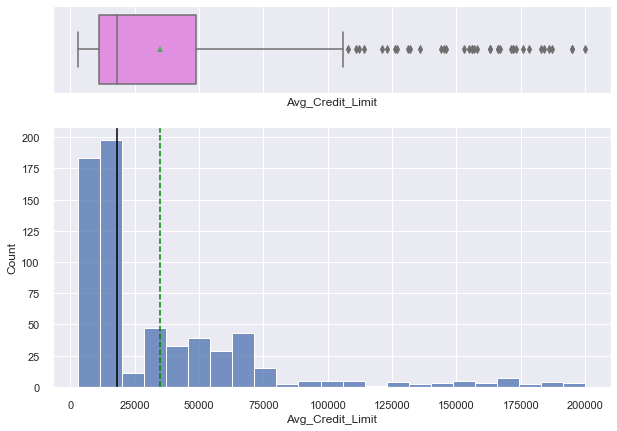

In [197]:
histogram_boxplot(df, 'Avg_Credit_Limit')

* Data are skewed, as we would expect with something like credit limit.
* There are many outliers according to the boxplot whiskers, however, given that the outliers tend to cluster together an no particular data point lies too far away from the other data points, the data are likely real.

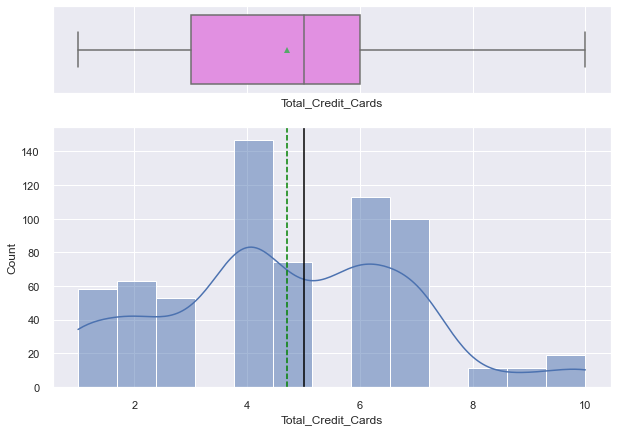

In [198]:
histogram_boxplot(df, 'Total_Credit_Cards', kde=True, bins=None)

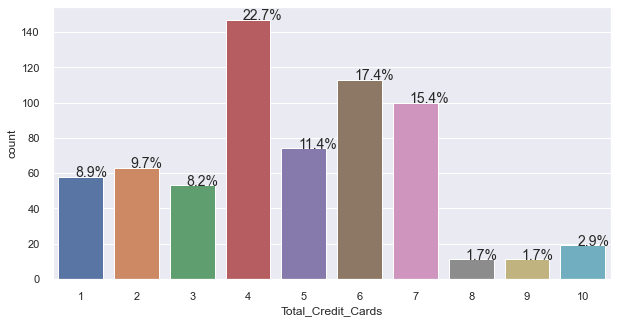

In [199]:
perc_on_bar(df["Total_Credit_Cards"])

* There are 10 possible values for Total_Credit_Cards. The highest concentration of customers is at 4 cards (23%). This is followed by 6 and 7 cards at 18% and 15% respectively. There are a small number of customers with 8 or more cards.
* The mode value is 4, however the median is 5, we can see that there is a small "tail" of values at 8 or above. We could experiment with clipping the data at 8, and making the value represent 8 or more cards.

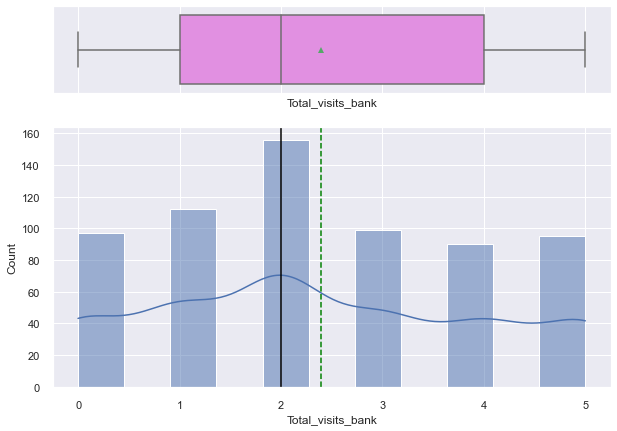

In [200]:
histogram_boxplot(df, 'Total_visits_bank', kde=True, bins=None)

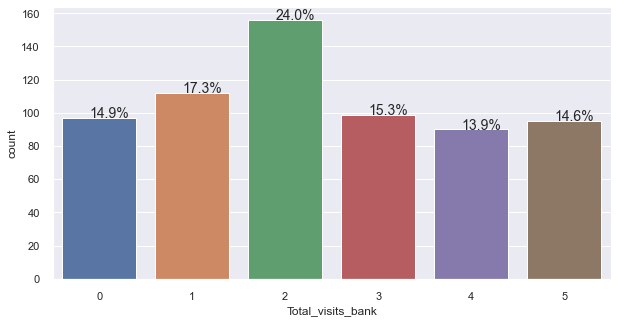

In [201]:
perc_on_bar(df["Total_visits_bank"])

* Distribution of the data is slightly skewed to the right.
* The most common number of in-person vistis is 2, accounding for 24% of customers. For all other number of visits, there is an even spread of customers (~14-17%) throughout the range.

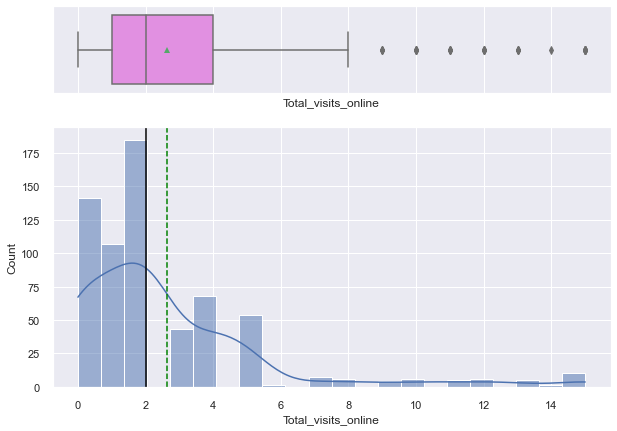

In [202]:
histogram_boxplot(df, 'Total_visits_online', kde=True, bins=None)

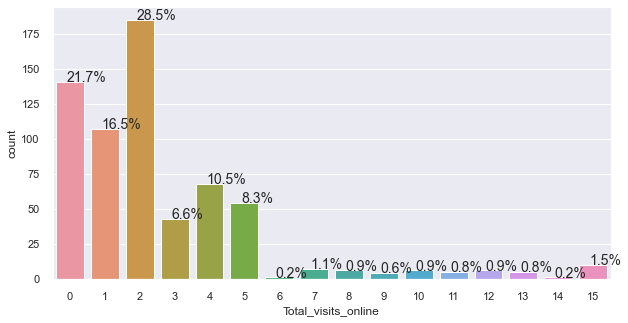

In [203]:
perc_on_bar(df["Total_visits_online"])

* The total number of visits is quite skewed. We have the vast majority of customers with 5 or less online visits. Then there is a small scattering of customers who have more online visits.
* The outliers are likely real, but they could cause an issue for our classification. We can experiment with clipping the data at 6 and having a "6 or more" online visit category.

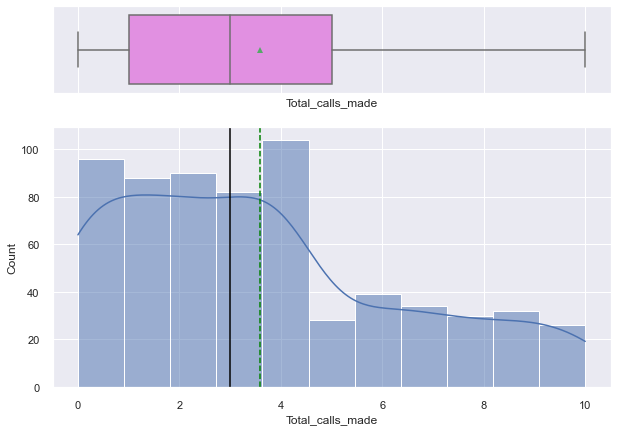

In [204]:
histogram_boxplot(df, 'Total_calls_made', kde=True, bins=None)

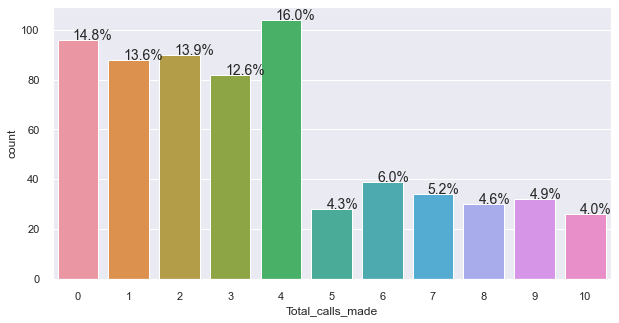

In [205]:
perc_on_bar(df["Total_calls_made"])

* The distribution can be roughly divided into two halves. The first half (0-4) has higher customer counts, the second half (5-10) has much lower customer counts.

# Bivariate Analysis

We will start to get a feel for the interactions between the variables by seeing how they are correlated and by looking at pair plots. 

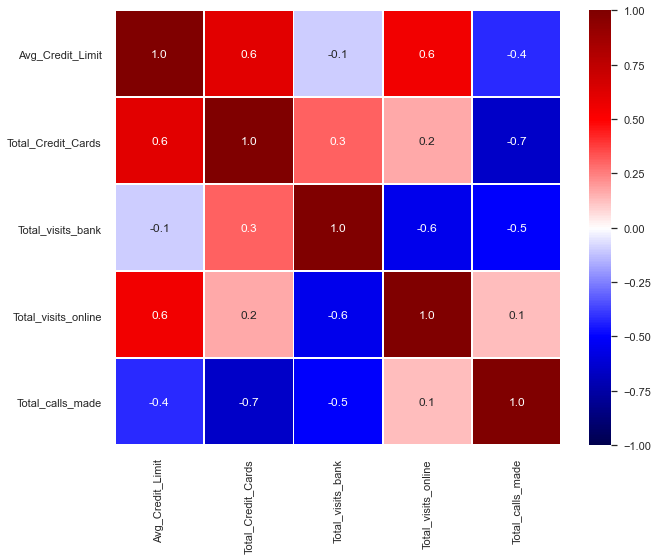

In [206]:
# Let's start by looking for correlation in the data
corr = df.corr()

sns.set(font_scale=1)
fix, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr, 
            cmap='seismic', annot=True,fmt=".1f",vmin=-1, vmax=1, center= 0,
            square=False, linewidths=.7);

**Observations**
* Avg_Credit_Limit
    - Positively correlated with Total_Credit_Cards. This makes sense as customers with more credit cards will likely have more credit available
    - Positively correlated with Total_visits_online. 
    - Negatively correlated with Total_calls_made. It appears customers with a higher credit limit prefer to interact wtih the bank online and don't call the call centre.
* Total_Credit_Cards
    - Highly negatively correlated with Total_calls_made. Customers with more cards are less likely to call the call centre. Conversely, customers with less cards are more likely to call the call centre.
* Total_visits_bank
    - Negatively correlated with Total_visits_online and Total_calls_made. This makes sense as customers who have a preference for visiting the bank in person are less likely to use the other methods of contacting the bank.
* Total_visits_online
    - Negatively correlated with Total_visits_bank. Customers who interact with the bank online are less likely to visit the bank. However, there is no correlation between Total_vistis_online and Total_calls_made.
* Total_calls_made
    - Negatively correlated with bank visits, total credit cards and total credit. It appears people who call the bank are less likely to have lots of cards and and a high credit limit. As we have seen before, customers who visit the bank in person are much less likely to contact the bank in other ways, including calls.

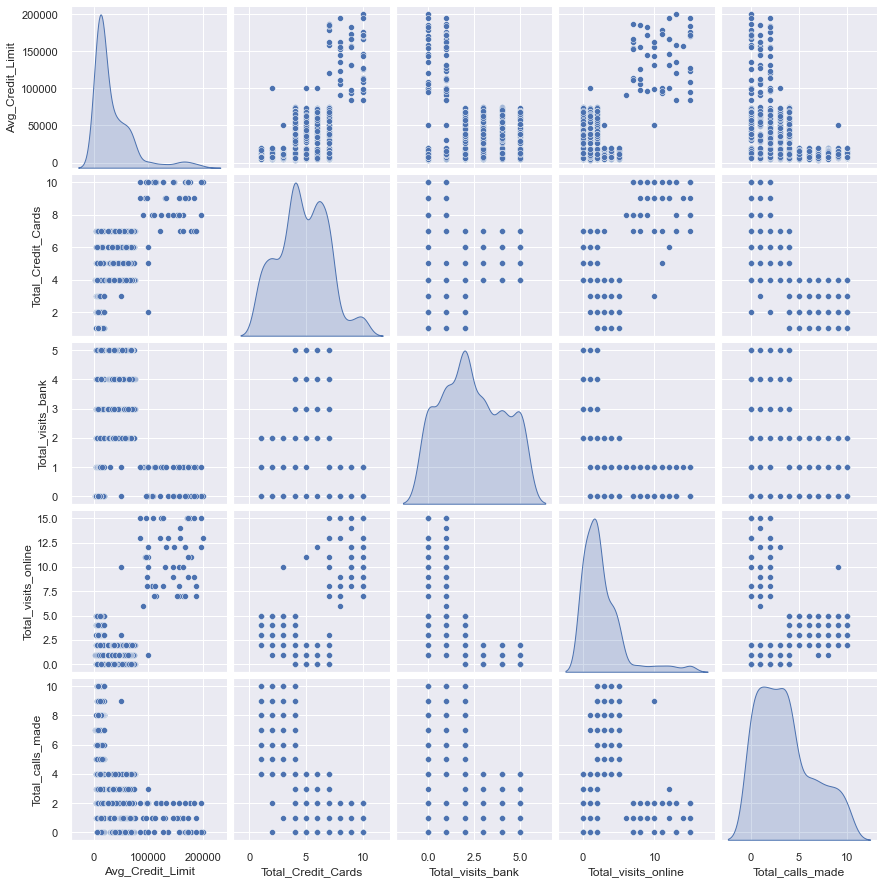

In [207]:
sns.pairplot(df, diag_kind='kde');

**Observations**

* We can already see from these 2D plots that the data do appear to form clusters. For example, customers with a high credit limit, tend to have more credit cards and interact with the bank online.
* Customers who visit the bank in person more often (3-5x), make less calls and online queries, tend to have a lower credit limit and tend to have 4-7 credit cards.
* Customers with a high values for Total_calls_made (5-10), tend to have a ver low credit limit and less than 5 credit cards.
* We can see from the KDE plots, that the Total_Credit_Cards and Total_visits_bank variables appear to have multiple modes.
* We can also see from the KDE plots (and the univariate analysis), that Ave_Credit_Limit, Total_visits_online and Total_calls_made appear to be split into two halves. The bulk of customers lie in the first (low values) half. The upper half accounts for much less of the customer base. The lower half appears to be normally distributed, the upper half is not.

# Data pre-processing
*Prepare the data for analysis - Feature Engineering - Missing value Treatment - Outlier Treatment - Duplicate observations check and removal if found*

### Missing value treatment:
There are no missing values in the data. We observed this in the Initial Data Read section of this notebook.

### Outlier Treatment:
* There are possible outliers at the max range of Avg_Credit_Limit, we will look at those and treat if necessary. 
* We can also experiment with clipping the range of Total_visits_online, given that there are so few customers who visit the bank online above 6 times. We can clip the range at 6 and experiment with this data set.
* Finally we can clip the values of Total_Credit_Cards to at 8 and see if this improves our clustering.

##### Outliers in Avg_Credit_Limit

In [208]:
# Let's look at the high values in Avg_Credit_Limit
df.sort_values(by='Avg_Credit_Limit', ascending=False).head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
630,200000,10,0,13,0
650,195000,10,1,12,2
631,195000,8,0,15,0
632,187000,7,1,7,0
646,186000,7,0,8,1


* The highest values in Avg_Credit_Limit do not sit that far away other data points. Furthermore, they conform to the pattern that we have seen in our Bivariate Analysis, i.e. the customers with the highest credit limit also have very high numbers of credit cards and interact with the bank mostly online. For these reasons, these data are likely real and as such we will not treat them.

##### Clip values in Total_visits_online

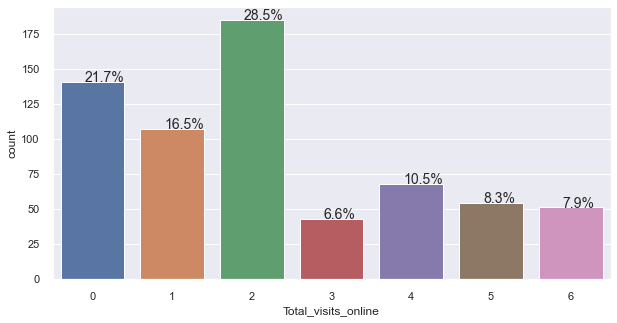

In [209]:
# Now lets clip the range in Total_visits_online

df_clip = df.copy() # make a separate data frame to hold the clipped version of Total_visits_online
df_clip["Total_visits_online"].clip(upper=6, inplace=True) # clip Total_visits_online
perc_on_bar(df_clip["Total_visits_online"]) # check the distribution afterwards

* We now have a separate data frame with a clipped version of Total_visits_online that we can test as in input into our clustering algorithms.
* The distribution after clipping looks good, we just need to remember that 6 now represents "6 or more"

##### Clip values in Total_Credit_Cards

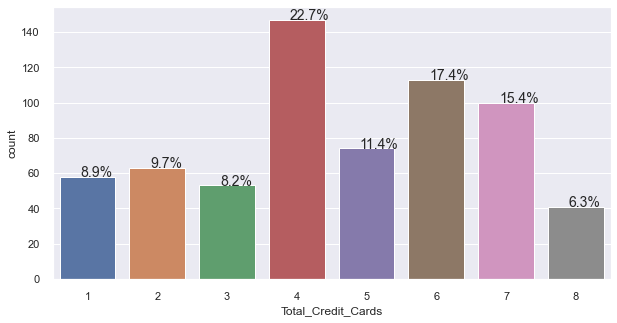

In [210]:
df_clip2 = df_clip.copy() # We will copy the data with Total_visits_online clipped and further alter it
df_clip2["Total_Credit_Cards"].clip(upper=8, inplace=True) # clip Total_Credit_Cards
perc_on_bar(df_clip2["Total_Credit_Cards"]) # check the distribution afterwards

* We now have a separate data frame with both Total_visits_online and Total_Credit_Cards clipped
* The distribution of Total_Credit_Cards looks good after we have clipped the higher values, our new "8 or more cards" category is still smaller than the other categories, so we haven't biased the distribution by creating a large category.

### Duplicate Observations:

We observed during our data load that there were duplicate rows while doing the necessary data exploration before dropping columns. We first looked at Sl_No and found there were no duplicates. We then looked at Customer Key only to find that this, "unique ID given to each customer in the database" was not actually functioning as expected. There were different customers with the same unique key!  
Finally, after dropping two columns we found that there were 11 duplicated rows. These have been removed as two points in the same location do not help us with our customer clustering.

### Scaling Data
Clustering methods are highly sensitive to differences in scale between variables. Most of our variables are scaled between 0-15 but Avg_Credit_Limit ranges from 3000-20000. We will apply a standard scalar to all variables, so that all our variables have a mean of 0 and standard deviation of 1.

In [211]:
columns = df.columns

scaler = StandardScaler() # set up our standard scalar

# Now fit and transform our scalar on each of our datasets.
df_ss = pd.DataFrame(scaler.fit_transform(df), columns=columns)
df_clip_ss = pd.DataFrame(scaler.fit_transform(df_clip), columns=columns)
df_clip2_ss = pd.DataFrame(scaler.fit_transform(df_clip2), columns=columns)

# Applying K-means Clustering Algorithms
*Apply K-means - Elbow curve - Silhouette Score - figure out appropriate number of clusters*

**Note:** K-means clustering is sensitive to the starting centroids chosen. We will be implementing the K-Means++ method to choose better starting centroids. We will also be running the algorithm 10 times, using a different random point as our initial  centroid. We have specified a random state such that each time the notebook is run the results are the same.

### Elbow Method

In [212]:
# As we will be testing three data sets, one with our original data, and 2 with clipped values in selected variables,
# let's write a function to perfrom our k-means using a number of clusters and plot the results on a k vs. distortion plot

def run_kmeans(dataset):
    clusters = range(1, 9)
    meanDistortions = []

    for k in clusters:
        model = KMeans(n_clusters=k, random_state=1)
        model.fit(dataset)
        prediction = model.predict(dataset)
        distortion = (
            sum(
                np.min(cdist(dataset, model.cluster_centers_, "euclidean"), axis=1)
            )
            / df_ss.shape[0]
        )

        meanDistortions.append(distortion)

        print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

    plt.figure(figsize=(15, 6))
    plt.plot(clusters, meanDistortions, "bx-")
    plt.xlabel("k")
    plt.ylabel("Average distortion")
    plt.title("Selecting k with the Elbow Method")

Number of Clusters: 1 	Average Distortion: 2.007896349270688
Number of Clusters: 2 	Average Distortion: 1.4576197022077821
Number of Clusters: 3 	Average Distortion: 1.1434401208195095
Number of Clusters: 4 	Average Distortion: 1.0435538595477063
Number of Clusters: 5 	Average Distortion: 0.9877896646529043
Number of Clusters: 6 	Average Distortion: 0.9402321120333815
Number of Clusters: 7 	Average Distortion: 0.9074090300543388
Number of Clusters: 8 	Average Distortion: 0.8869431084515197


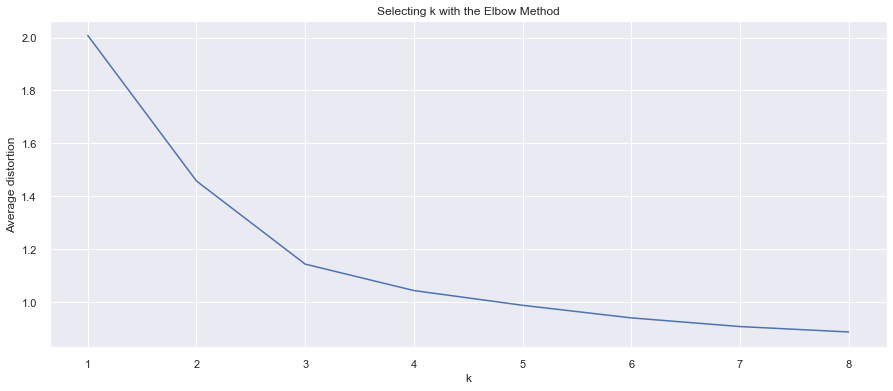

In [213]:
run_kmeans(df_ss)

* Our "elbow" appears to be when k = 3 or 4.
* Let's check to see if clipping Total_visits_online affects the clustering.

Number of Clusters: 1 	Average Distortion: 2.0631801184022422
Number of Clusters: 2 	Average Distortion: 1.4735899613859609
Number of Clusters: 3 	Average Distortion: 1.1802399452572234
Number of Clusters: 4 	Average Distortion: 1.0848383224053795
Number of Clusters: 5 	Average Distortion: 1.033309428470542
Number of Clusters: 6 	Average Distortion: 0.9880491742695809
Number of Clusters: 7 	Average Distortion: 0.9545493646988862
Number of Clusters: 8 	Average Distortion: 0.9248775961016147


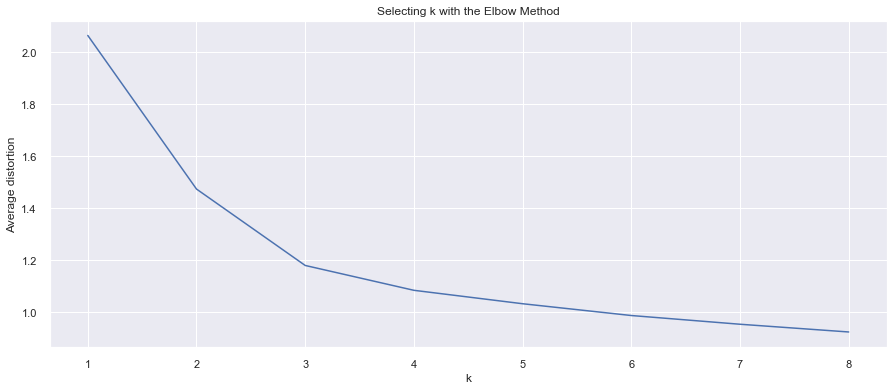

In [214]:
run_kmeans(df_clip_ss)

* Our elbow still appears to be at 3 or 4.
* Surprisingly, our average distortion has increased as a result of clipping values in Total_visits_online.
* Let's check to see what happens when we additionally clip values in Total_Credit_Cards:

Number of Clusters: 1 	Average Distortion: 2.0764724969055854
Number of Clusters: 2 	Average Distortion: 1.4764579014839834
Number of Clusters: 3 	Average Distortion: 1.1866407584620253
Number of Clusters: 4 	Average Distortion: 1.092384856155801
Number of Clusters: 5 	Average Distortion: 1.041526483648267
Number of Clusters: 6 	Average Distortion: 0.9970547760266469
Number of Clusters: 7 	Average Distortion: 0.9635071725120861
Number of Clusters: 8 	Average Distortion: 0.9309599970973678


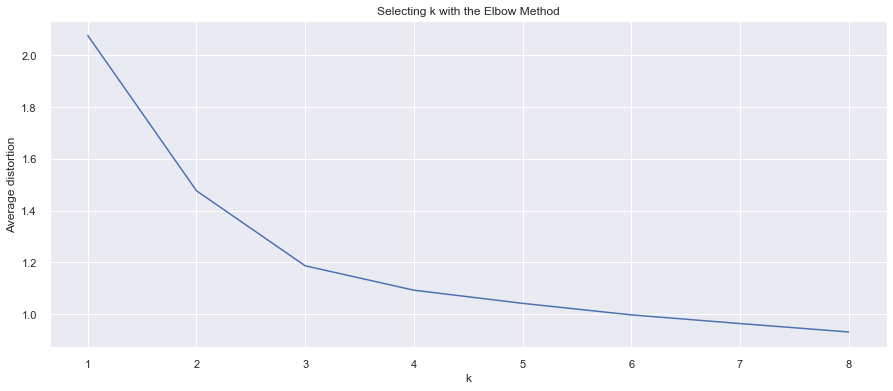

In [215]:
run_kmeans(df_clip2_ss)

* Again, our elbow appears to be at k = 3 or 4.
* Again we see an increase in distortion at each value of K as a result of clipping data.

### Silhouette Score

In [216]:
# We will again test our 3 data sets, so we will define a function to run our silhouette scores and plot a QC plot

def sil_scores(dataset):
    sil_score = []
    cluster_list = list(range(2, 10))
    for n_clusters in cluster_list:
        clusterer = KMeans(n_clusters=n_clusters, random_state=1)
        preds = clusterer.fit_predict((dataset))
        # centers = clusterer.cluster_centers_
        score = silhouette_score(dataset, preds)
        sil_score.append(score)
        print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

    plt.plot(cluster_list, sil_score)

For n_clusters = 2, silhouette score is 0.41800025566689647)
For n_clusters = 3, silhouette score is 0.516281010855363)
For n_clusters = 4, silhouette score is 0.3570238219413198)
For n_clusters = 5, silhouette score is 0.2730908848204728)
For n_clusters = 6, silhouette score is 0.2569035285862428)
For n_clusters = 7, silhouette score is 0.24820100806368722)
For n_clusters = 8, silhouette score is 0.22702515587520655)
For n_clusters = 9, silhouette score is 0.227895517040229)


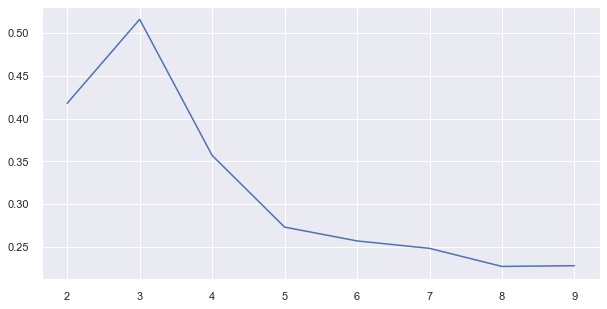

In [217]:
sil_scores(df_ss)

For n_clusters = 2, silhouette score is 0.4328336312382268)
For n_clusters = 3, silhouette score is 0.5245486561227092)
For n_clusters = 4, silhouette score is 0.3505437762009073)
For n_clusters = 5, silhouette score is 0.25855562488733597)
For n_clusters = 6, silhouette score is 0.24204246793077172)
For n_clusters = 7, silhouette score is 0.23925909210892624)
For n_clusters = 8, silhouette score is 0.23085744970914676)
For n_clusters = 9, silhouette score is 0.23209301838617238)


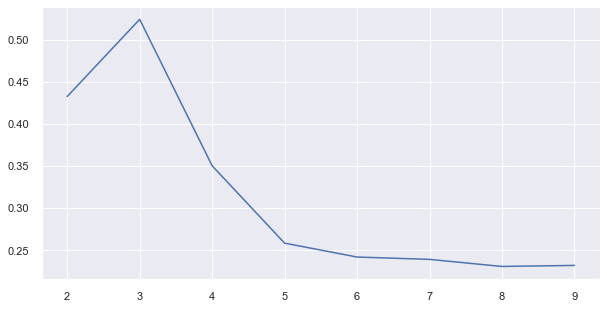

In [218]:
sil_scores(df_clip_ss)

For n_clusters = 2, silhouette score is 0.4363977919489601)
For n_clusters = 3, silhouette score is 0.5273348609870895)
For n_clusters = 4, silhouette score is 0.3508200113869671)
For n_clusters = 5, silhouette score is 0.2568330958995109)
For n_clusters = 6, silhouette score is 0.23983245861205355)
For n_clusters = 7, silhouette score is 0.23501610369545725)
For n_clusters = 8, silhouette score is 0.23168144577862038)
For n_clusters = 9, silhouette score is 0.22040814890444288)


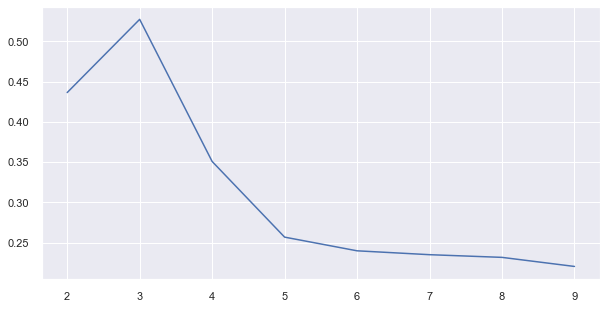

In [219]:
sil_scores(df_clip2_ss)

* The silhouette scores indicate that 3 is the best number of clusters.
* It is interesting to note that our clipped data sets had a higher distortion compared to the unclipped data. However, the silhouette scores are higher for the clipped data indicating that points are more similar to other in-cluster points (and more dissimilar from out-of-cluster points) when we use the clipped data. The difference is not particually high and it does not change the optimum number of clusters, so it likely does not matter which data set we use as input in this particular case. **We will use the unclipped data, as it will be easier to relate results to our original data set if we use the least altered data**

Below we will plot the silhouetter visualizer for our original data

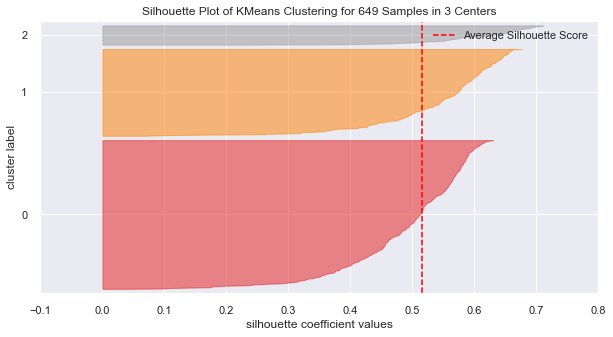

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 649 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [220]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(df_ss)
visualizer.show()

* We can see that each of the three clusters (represented by the different colours are well balanced, i.e. they have similar silhouette scores. We will compare this to k= 4 and 5.

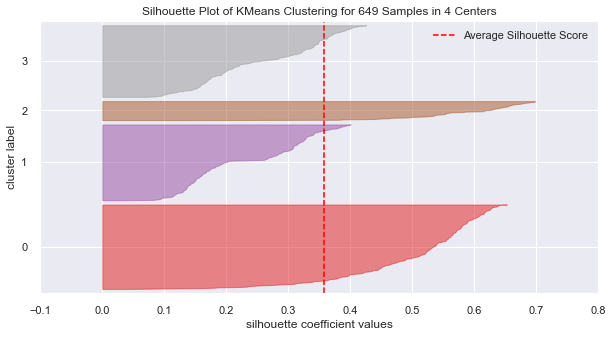

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 649 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [221]:
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(df_ss)
visualizer.show()

* When k = 4 we can see that the average silhouette coefficient drops and that some of the clusters have better scores than others.

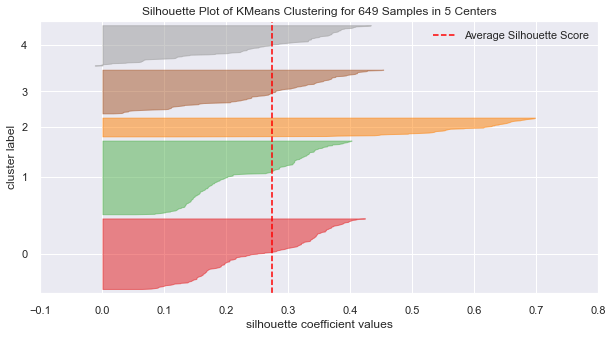

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 649 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [222]:
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(df_ss)
visualizer.show()

* Finally, when k = 5, we can see that the silhouetter coefficient drops further. 4 of the clusters are well balanced (with low scores), while one cluster, of less points, has a higher score.
* **Overall, we can see that k = 3 gives us the best results. We will move forward with 3 clusters.** When k=3 there is clear knick in the elbow and the silhouette scores peak when k = 3. Furthermore the Sihouette Visualizer indicates that clusters are the most balanced with the highest average silhouette score when k = 3.

### Add Cluster Labels to Data

In [223]:
# let's take 3 as number of clusters. We will run the KMeans again (using the same random state)
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(df_ss)

KMeans(n_clusters=3, random_state=1)

In [224]:
# Now we append the centroid labels to our original, unscaled data frame
df["K_means_segments"] = kmeans.labels_

In [225]:
df.head() # Let's take a look at our df again. We can see there is an extra row showing which cluster the data belongs to.

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments
0,100000,2,1,1,0,1
1,50000,3,0,10,9,0
2,50000,7,1,3,4,1
3,30000,5,1,1,4,1
4,100000,6,0,12,3,2


In [226]:
# We will now create a "cluster profile". We will group the data by the cluster number and 
# find the mean for each variable in each cluster
cluster_profile = df.groupby("K_means_segments").mean()

# Below we find the number of points in each cluster
cluster_profile["count_in_each_segments"] = (
    df.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

In [227]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
K_means_segments,,,,,,
0,12239.819005,2.411765,0.945701,3.561086,6.891403,221
1,34071.428571,5.518519,3.484127,0.981481,1.992063,378
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


* The table above shows the mean value for each variable within each cluster.
    - Cluster 0: Customers with the lowest Credit Limit and Total Credit Cards. These customers prefer to contact the bank via telephone. There are 221 customers in this cluster
    - Cluster 1: Customers with average Credit Limit and Total Credit Cards. These customers use all forms of contact but prefer to visit the bank in person. There are 378 customers in this cluster, as this is our "middle" cluster, it makes sense that more customers fit into this cluster
    - Cluster 2: Customer with high Credit Limit and Total Credit Cards. These customers have a strong preference for contacting the bank online. There are only 50 points in this cluster. As we saw during our EDA, there are less customers with very high credit limits.

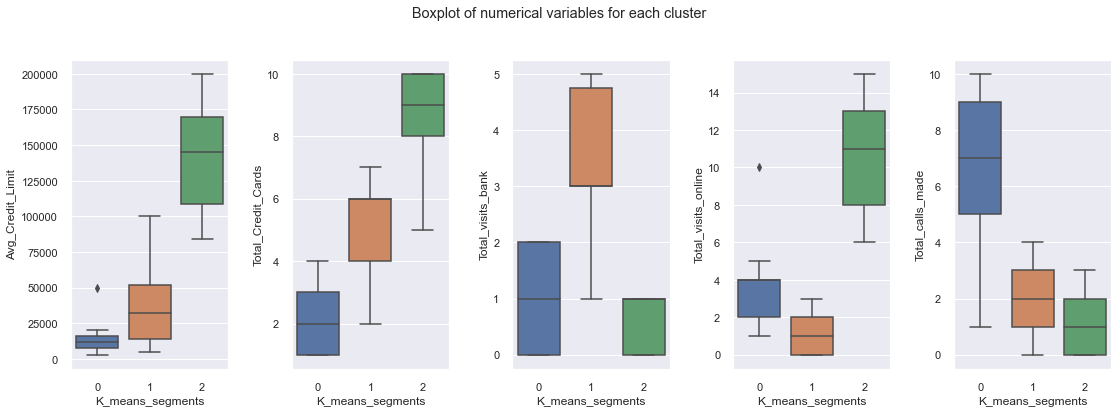

In [228]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[df.columns[counter]], x=df["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

* The plots above show the entire range of values for each variable for each cluster. The table slightly higher up the page shows the mean values and number of points for each cluster.
* We will examine the contents of each cluster in more detail in the section: "Compare cluster K-means clusters and Hierarchical clusters - Perform cluster profiling - Derive Insights" further down in the notebook.
* In cluster 0 there is one outlier in both Avg_Credit_Limit and Total_visits_online. Let's see if this is the same customer.

In [229]:
df[df['K_means_segments']==0].sort_values(by='Avg_Credit_Limit', ascending=False).head(1)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments
1,50000,3,0,10,9,0


* We can see that the outier in cluster zero, the customer with the high Avg_Credit_Limit, is the same customer with the outlying value (for cluster zero) in Total_vists_online. We have seen in our EDA that customers with higher credit limits tend to prefer contacting the bank online. 

# Applying Hierarchical clustering
*Apply Hierarchical clustering with different linkage methods - Plot dendrograms for each linkage methods - Choose appropriate number of cluster*

## Cophenetic Correlation

We will use the Agglomerative Clustering for of Hierarchical clustering. In this method, all points start as single points. We measure the **distance** between all points and the closest two points are joined into a cluster. Once we have a cluster we need some way of measuring the distance between points and clusters or the distance between two clusters, this is where the concept of **linkage** comes in. There are different methods for measuing **distance** and **linkage**, we will decide which method is best using the **cophenetic correlation**

In the code below we combine different distance and linkage methods and compare their cophenetic correlations. There are some linkage methods that only work when the distance metric is Euclidean, we will look at these next.

In [230]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"] #note: cityblock is Manhattan Distance

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

# make some empty variables
high_cophenet_corr = 0
high_dm_lm = [0, 0]

# run through each combo of distance and linkage and find Cophenetic correlation
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(df_ss, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(df_ss))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:  # if cophenetic corr higher than previous max, set new max, record distance and linkage
            high_cophenet_corr = c
            high_dm_lm[0] = dm   
            high_dm_lm[1] = lm
            
# print the combination of distance metric and linkage method with the highest cophenetic correlation
print('\n')
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Cophenetic correlation for Euclidean distance and single linkage is 0.7395135051413775.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8794736468795109.
Cophenetic correlation for Euclidean distance and average linkage is 0.8974425535306298.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8551098644586315.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7379112982920528.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8578617029322211.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8960370054789858.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.893309534644998.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7054746377393304.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6165028065519298.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8330283182400026.
Cophenetic cor

* We can see from the scores above that our highest cophenetic correlation comes when we use the Euclidan distance metric with the average linkage method.
* Our other high scores also appear to occur when average linkage is used as the method. For example the Cityblock distance, average linkage score and Chebyshev distance, average linkage scores are also very high.
* Below we will test linkage methods that only work with Euclidean distance. We will compare these with the other methods using Euclidean distance.

In [231]:
# list of linkage methods. We will use the methods as before plus two new methods that only work with Euclidean distance.
linkage_methods = ["single", "complete", "average", "weighted", "centroid", "ward"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(df_ss, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(df_ss))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

print('\n')
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Cophenetic correlation for single linkage is 0.7395135051413775.
Cophenetic correlation for complete linkage is 0.8794736468795109.
Cophenetic correlation for average linkage is 0.8974425535306298.
Cophenetic correlation for weighted linkage is 0.8551098644586315.
Cophenetic correlation for centroid linkage is 0.894471288720818.
Cophenetic correlation for ward linkage is 0.7425813590948763.


Highest cophenetic correlation is 0.8974425535306298, which is obtained with average linkage.


* Our highest copheneitc correlation still occurs when we use Euclidean distance with average linkage.
* Our second highest score was Cityblock distance and average linkage at 0.896.

## Dendrograms

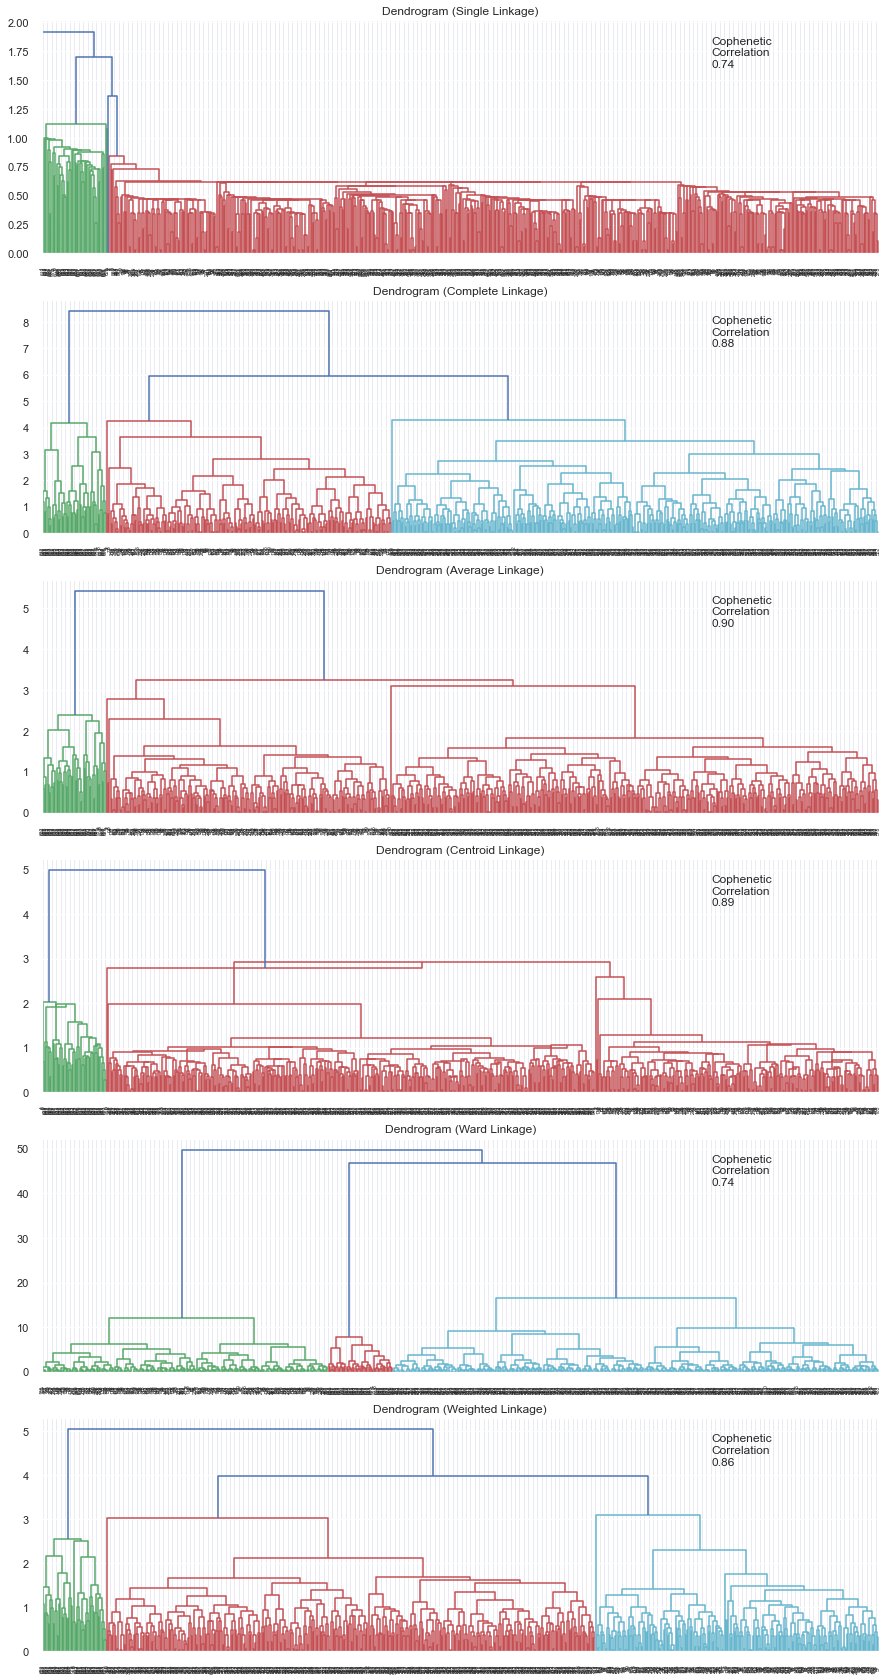

In [232]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(df_ss, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(df_ss))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

In [233]:
# let's create a dataframe to compare cophenetic correlations for each linkage method
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc

,Linkage,Cophenetic Coefficient
0,single,0.739514
1,complete,0.879474
2,average,0.897443
3,centroid,0.894471
4,ward,0.742581
5,weighted,0.855110


**Observations**
* Single Linkage: This method indicates that 2 clusters is best. If we attempted to increase cluster numbers to 3, one cluster would contain very little data and one cluster would contain almost the entire data set. It is clear that this is not the best linkage method to use.
* Complete Linkage: With this method we could produce 3 or 4 clusters, with the data fairly well distributed throughout. However this method did have a low Cophenetic Coefficent.
* Average Linkage: This method indicates 3 clusters. If we attempted to increase the number of clusters above 3, we would find clusters with very few points in them. This method did have the highest Cophenetic Coefficient.
* Centroid Linkage: Again we see that 3 clusters is the optimum using this method. Again, increasing clusters above 3 would lead to some clusters containing only a few data points.
* Ward Method: This method created some very distict clusters. We could chose 3-5 clusters using this method and have good distribution of data into each cluster. However the Cophenetic Coefficient for this method is low compared to the other methods.
* Weighted Linkage: This method would indicates that 2 clusters is best. If we attempted to increase cluster numbers to 3 we would find one cluster with very litte data and one cluster with almost the entire data set. Despite the high Cophenetic Coefficient, this is not a good method for this data set.

### Create Dendrograms for Clipped Data
We saw that, in a number of the methods above (Single Linkage and Weighted Linkage), increasing the number of clusters above 2 would lead to one cluster having very few data points. This could be due to outliers. Let's look at the dendrograms again, however this time we will use our dataset where Total_Credit_Cards and Total_visits_online have been clipped.

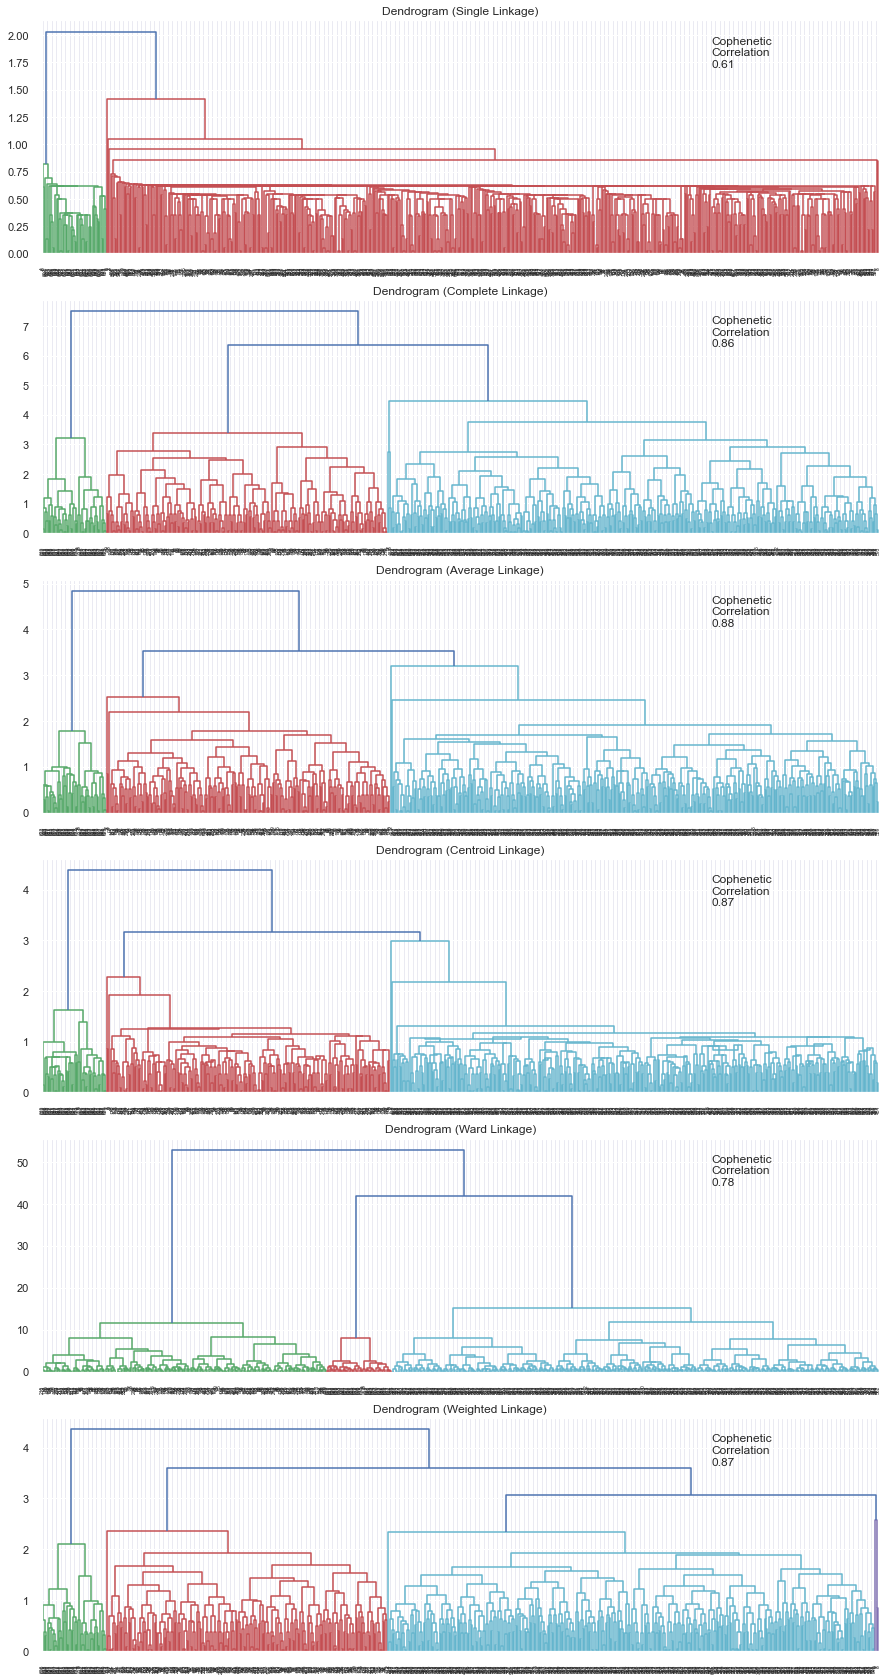

In [234]:
# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare2 = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(df_clip2_ss, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(df_clip2_ss))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare2.append([method, coph_corr])

In [235]:
# let's create a dataframe to compare cophenetic correlations for each linkage method
df_cc2 = pd.DataFrame(compare2, columns=compare_cols)
df_cc2

,Linkage,Cophenetic Coefficient
0,single,0.613014
1,complete,0.860725
2,average,0.880561
3,centroid,0.874939
4,ward,0.776988
5,weighted,0.870077


**Observations**
* By inputing the clipped data, Cophenetic Coefficient scores have dropped for all methods, apart from Ward, which has slightly increased from 0.76 to 0.78.
* Single Linkage: Despite using the clipped data, number of clusters could not be increased above 2. This method remains poor for this data set.
* Complete Linkage: Again, indicates 3 clusters as the optimum number. Cophenetic Coefficient has dropped slightly from original data.
* Average Linkage: Indicates 3 clusters, attempts to increase number of clusters would lead to unbalanced clusters. This has not improved as a result of the clipped input data.
* Centroid Linkage: No real change as a result of the clipped data. Limit of clusters is still 3.
* Ward Method: Cophenetic Coefficent has increased. It also appears that we could make 3-6 clusters fairly even distributions between the clusters. We could experiment with this and see if the clusters are distinct and meaningful.
* Weighted Linkage: This method does a little better with the clipped data, we could now make 3 meaningful clusters rather than just 2. However, again this method is certainly not our best option.

**Best Models**
* The model with the highest Cophenetic Coefficient is Euclidian Distance with Average Linkage (and unclipped data as input).
* The model which creates the highest number of meaningful clusters is Ward Method. With unclipped data we can get anywhere from 3-5 clusters. When we use the clipped data we can get 3, 4 or 6.
* To simplify things, we will use the unclipped data both times and produce clusters from the Average Linkage and Ward Method and compare them to each other (and our k-means clusters)

### Cluster Profiling HC - Euclidean Distance, Average Linkage, N=3

In [236]:
# Let's create a model using 3 clusters
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
HCmodel.fit(df_ss)

# Add the labels to our data frame
df["HC_Clusters"] = HCmodel.labels_

In [237]:
df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,HC_Clusters
0,100000,2,1,1,0,1,0
1,50000,3,0,10,9,0,2
2,50000,7,1,3,4,1,0
3,30000,5,1,1,4,1,0
4,100000,6,0,12,3,2,1


* We can see that the data frame now contains labels from our Hierarchical Clustering (HC_Clusters) as well as our K-means Clustering.

In [238]:
# We will now create a "cluster profile". We will group the data by the cluster number and 
# find the mean for each variable in each cluster
cluster_profile_HC = df.groupby("HC_Clusters").mean()

# Below we find the number of points in each cluster
cluster_profile_HC["count_in_each_segments"] = (
    df.groupby("HC_Clusters")["Avg_Credit_Limit"].count().values
)

#### Cluster Means and No. Points HC, Euclidean Distance, Average Linkage, N=3

In [239]:
cluster_profile_HC.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,count_in_each_segments
HC_Clusters,,,,,,,
0,34000.000000,5.514512,3.480211,0.984169,1.997361,0.997361,379
1,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,50
2,12263.636364,2.404545,0.940909,3.568182,6.904545,0.000000,220


* It appears that our clusters from our Hierarchical Clustering as *exactly* the same as our k-means clusters. The number of each cluster is different but the number of points and the mean values are exactly the same.
* Below we will reproduce our cluster profile table from the k-means clustering to compare.

#### Cluster Means and No. Points k-means clustering, k=3 (For comparison)

In [240]:
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
K_means_segments,,,,,,
0,12239.819005,2.411765,0.945701,3.561086,6.891403,221
1,34071.428571,5.518519,3.484127,0.981481,1.992063,378
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


* We can see that the numbering of the clusters is different but the clusters produced are exactly the same.
* Our k-means cluster 0 is the same as the HC cluster 2. K-means cluster 1 is the same as HC cluster 0 and k-means cluster 2 is the same as HC cluster 1.
* We don't know for certain that every point in the clusters are the same, but given that the number of points and the mean values, down to 6 decimal places are the same. It is likely that both methods produced exactly the same clusters.
* Given that both methods produced the same clusters, our confidence in these clusters increases.
* Let's look now at the model that created the highest number of meaningful clusters, Ward Method N=5

### Cluster Profiling HC - Euclidean Distance, Ward Method, N=5

In [241]:
# Let's create a model using 3 clusters
HCmodel = AgglomerativeClustering(n_clusters=5, affinity="euclidean", linkage="ward")
HCmodel.fit(df_ss)

# Add the labels to our data frame
df["HC_Clusters_Ward"] = HCmodel.labels_

In [242]:
df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,HC_Clusters,HC_Clusters_Ward
0,100000,2,1,1,0,1,0,0
1,50000,3,0,10,9,0,2,3
2,50000,7,1,3,4,1,0,0
3,30000,5,1,1,4,1,0,0
4,100000,6,0,12,3,2,1,2


* We can see that we have now added labels from our Hierarchical clustering with Ward Method to our data frame.

In [243]:
# We will now create a "cluster profile". We will group the data by the cluster number and 
# find the mean for each variable in each cluster
cluster_profile_HC_Ward = df.groupby("HC_Clusters_Ward").mean()

# Below we find the number of points in each cluster
cluster_profile_HC_Ward["count_in_each_segments"] = (
    df.groupby("HC_Clusters_Ward")["Avg_Credit_Limit"].count().values
)

# let's display cluster profiles
cluster_profile_HC_Ward.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,HC_Clusters,count_in_each_segments
HC_Clusters_Ward,,,,,,,,
0,38906.593407,5.719780,2.510989,0.972527,2.043956,1.000000,0.000000,182
1,29697.435897,5.333333,4.400000,0.984615,1.933333,1.000000,0.000000,195
2,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,1.000000,50
3,12549.019608,2.205882,0.852941,3.705882,8.627451,0.000000,2.000000,102
4,11933.333333,2.608333,1.033333,3.425000,5.391667,0.008333,1.966667,120


* When we custer using Ward Method, cluster 2 is exactly the same as the one of the clusters we have seen in both the k-means and Hierachical Clustering with Average Linkage (HC_Avg_Link). This cluster contains the customers with the highest credit limit, highest number of cards and a strong preference for visiting the bank online.
* For the other 4 clusters. The Ward Method has split the 2 clusters we saw in k-means and HC_Avg_Link and split each one into two. For example our k-means cluster zero and HC_Avg_Link cluster zero were exactly the same. The Ward Method has broken this cluster into two clusters.
* We will examine the contents of each cluster in more detail in the next section.

# Compare K-means clusters and Hierarchical clusters - Perform cluster profiling - Derive Insights
*Compare clusters obtained from k-means and hierarchical clustering techniques - Perform cluster profiling - Insights about different clusters*

Let's first look at our clusters in detail, i.e. our cluster profiles, we will then compare the different techniques.

### Cluster Profiles from K-means (k=3) and Hierarchical Clustering (n=3)
* For k-means we found the optimum number of clusters using both the elbow method and by looking at the silhouette scores. The optimum number of clusters was found to be 3. 
* For Hierarchical Clustering, we experimented with a number of distance measures and linkage methods. The combination with the highest Cophenetic Coefficient was Euclidean distance with average linkage. Looking at the dendrogram, we could have split the data into 2 or 3 clusters. If we had chosen 2 the clusters would have been very unbalanced, with almost all data falling into 1 cluster. As our goal was to segment the customers, this was not very useful. If we attempted to choose 4 clusters, we would again have one cluster with very few data points. For this reason, 3 was the optimum number of clusters to choose.
* **For both methods, the optium number of clusters was 3. Furthermore, both methods created exactly the same clusters.**
* As the cluster profiles for both methods are exactly the same, we will only need to show the cluster profiles for one method. We will choose the hierarchical clustering (n=3) as the plots for the k-means clustering are shown earlier in this notebook.
* **Below we will show the cluster means, number of points in each cluster and then full cluster ranges.**

#### Cluster Means and Number of Points

In [244]:
cluster_profile_HC.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,count_in_each_segments
HC_Clusters,,,,,,,
0,34000.000000,5.514512,3.480211,0.984169,1.997361,0.997361,379
1,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,50
2,12263.636364,2.404545,0.940909,3.568182,6.904545,0.000000,220


#### Cluster Ranges

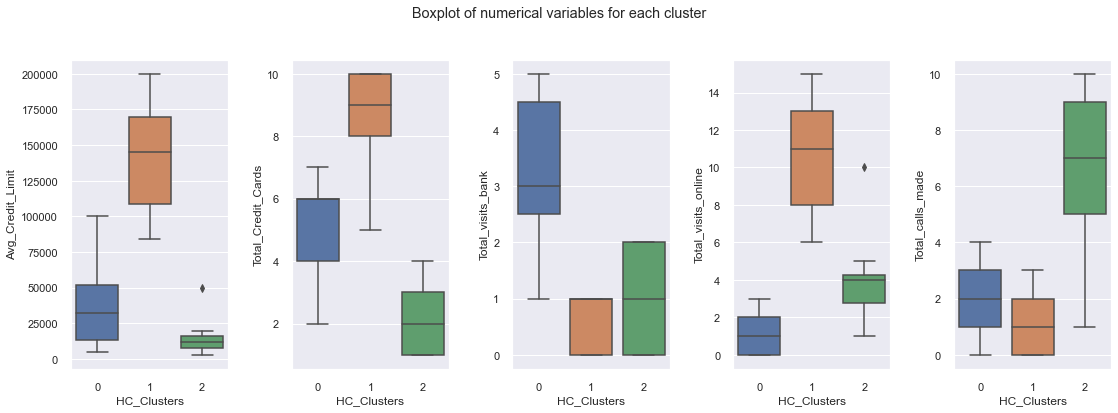

In [245]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[df.columns[counter]], x=df["HC_Clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

* Above we have a table that shows the mean value for each variable for each of the HC clusters and the number of points in each cluster
* Cluster Zero "The Average Customer":
    - This is the equivalent to k-means cluster 1. This cluster contains customers with an average Avg_Credit_Limit value (the average for all customers is 34878 the average for customers within this cluster is 34071). These customers have (on average 5-6 credit cards. They are the most likely to contact the bank by visiting in person and least likely to contact the bank online. This cluster contains the highest number of points (378), which we would expect given that it contains our "middle-of-the-road" customers, i.e. our customers with average credit limits and average number of cards.
* Cluster One "The High Credit Limit Customer":
    - This is the equivalent to k-means cluster 2. This cluster contains customers with the highest Avg_Credit_Limit and highest Total_Credit_Cards. We saw in our EDA that Avg_Credit_Limit had a highly right skewed distribution and that there were many customers to the right of our right whisker in our box plot. This cluster contains these customers. These customers are also ourliers in terms of the Total_Credit Cards. Only ~6% of customers have 8-10 credit cards and the interquartile range (IQR) of Total_Credit_Cards for this cluster is 8-10. These customers have a strong preference for contacting the bank online, we can see that the IQR for Total_visits_online is much higher in this cluster than the other 2. These customers are the least likely to contact the bank via phone or in person, the IQR for both Total_visits_bank and Total_calls_made is lowest for this cluster. As mentioned, this cluster contains the loweres amount
* Cluster Two "The Low Credit Limit Customer":
    - This cluster is equivalent to k-means cluster 0. This cluster contains customers with the lowest Avg_Credit_Limit and lowest Total_Credit_Cards. These customers are the most likely to contact the bank on the phone but also make use of the other methods of contact; they are not the lowest cluster for either Total_visits_bank or Total_visits_online. This cluster is the second largest at 221 points from 649. These customers are not as common as "Average Customers" but customers with lower credit limits (and likely lower income) are much more common than high credit limit customers. Note: There is one outlier in this cluster. This customer has a higher Avg_Credit_Limit than the other customers, but the same 
    
* Comments on the clusters:
    - Each cluster has a clear preference for how they contact the bank. "The High Credit Limit Customer" cluster (HC cluster one), have a strong preference for contacting the bank online. "The Average Customer" cluster (HC cluster zero), has a preference for visiting the bank in person. Finally, "The Low Credit Limit Customer" cluster (HC cluster two), prefers to contact the bank on the phone.
    

### Cluster Profiles from and Hierarchical Clustering using Ward Method (n=5)
We also created clusters using the Ward Method in hierarchical clustering and created 5 clusters. This method recreated the "High Credit Limit Customer" cluster that we saw using k-means (k=3) and hierarchical clustering (n=3). The other two clusters were further broken down, let's look at that now:

#### Cluster Means and Number of Points

In [246]:
cluster_profile_HC_Ward.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,HC_Clusters,count_in_each_segments
HC_Clusters_Ward,,,,,,,,
0,38906.593407,5.719780,2.510989,0.972527,2.043956,1.000000,0.000000,182
1,29697.435897,5.333333,4.400000,0.984615,1.933333,1.000000,0.000000,195
2,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,1.000000,50
3,12549.019608,2.205882,0.852941,3.705882,8.627451,0.000000,2.000000,102
4,11933.333333,2.608333,1.033333,3.425000,5.391667,0.008333,1.966667,120


#### Cluster Ranges

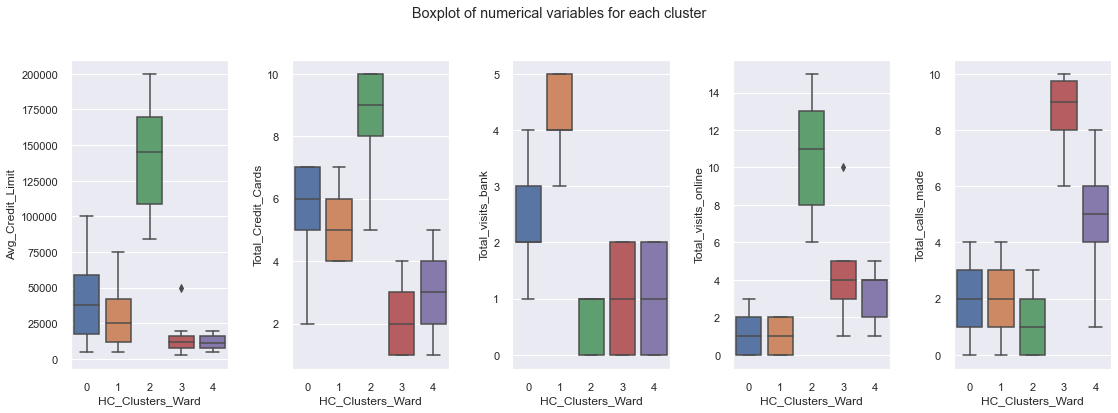

In [247]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[df.columns[counter]], x=df["HC_Clusters_Ward"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

* Above we have a table that shows the mean value for each variable for each of the HC clusters and the number of points in each cluster
* Cluster Two "The High Credit Limit Customer"
    - This cluster is exactly the same as the cluster we saw in our k-means and HC (n=3) clusters. It has remained unchanged when we use the Ward Method and increase the number of clusters. For a description of
* Cluster Zero "The Average Customer - Low Contact Version"
    - This is a subcluster of "The Average Customer" that we described above (when k or n=3). The main difference between this cluster and cluster one, is that the customers in this cluster contacted the bank less often. We can see that customers in this cluster still have a preference for contacting the bank in person, but Total_visits_bank is lower than for cluster one. Compared with cluster one, these customers also have a slightly higher Avg_Credit_Limit and more Total_Credit_Cards but there is still a high amount of overlap over the IQR of this cluster and cluster one in these variables.
* Cluster One "The Average Customer - High Contact Version"
    - This is a subcluster of "The Average Customer" that we described above (when k or n=3). The main difference between this cluster and cluster zero is that the Total_visits_bank is lower. Given that Total_visits_online and Total_calls_made is very similar, we can conclude that customers in this cluster contact the bank more often than customers in cluster zero. They also use the prefered method of contact for "The Average Customer", in person visits.
* Cluster Three "The Low Credit Limit Customer - High Contact Version"
    - This is a subcluster of "The Low Credit Limit Customer" that we described above (when k or n=3). The main difference between this cluster and cluster four is that the total number of times customers in this cluster have contacted the bank. You can see that the Total_calls_made is much higher in this cluster than in cluster 4. The Total_visits_online is also slightly higher in this cluster. Customers in this cluster are also have slightly less credit cards than those in cluster 4.
* Cluster Four "The Low Credit Limit Customer - Low Contact Version"
    - This is a subcluster of "The Low Credit Limit Customer" that we described above (when k or n=3). As described in the last point, there is little difference between cluster four and three, the main difference is that the values for Total_calls_made (the preferred method for contacting the bank for "The Low Credit Limit Customer"), is lower in cluster four than in cluster three.

### Comparing K-means clusters with Hierarchical Clusters
Now that we have looked at our cluster profiles for the different methods we have used. Let's compare the methods themselves:  

The FAQ provided with this project provides the following questions to answer when comparing the K-means clusters with Hierarchical clusters:
* Which clustering technique took less time for execution?
* Which clustering technique gave you more distinct clusters, or are they the same?
* How do the silhouette scores vary?
* How many observations are there in the similar clusters of both algorithms?
* How many clusters are obtained as the appropriate number of clusters from both algorithms?
We will go through each of these questions in turn.

#### Which clustering technique took less time for execution?
The clustering technique that took the least time was k-means clustering. Not only is this technique known to be computationally less expensive (and it did compute faster for me in this project), it also took less time to actually implement the technique.  
It was much easier and faster to compute the Average Distortion and Silhouette Scores and make a decision on the number of clusters to use based on these scores vs. k than it was to plot the dendrograms, interpret them and decide on the number of clusters to use.

#### Which clustering technique gave you more distinct clusters, or are they the same?
If we were to just consider the “optimum” number of clusters, where for k-means, the optimum number was decided with the silhouette score and for hierarchical clustering, the optimum number of clusters was chosen from the dendrogram using the method with the highest Cophenetic Coefficient: The number of clusters is 3 for both methods.
Furthermore, both methods, when the number of clusters was 3, k-means and hierarchical clustering produced exactly the same clusters. This at least gives us confidence in our clusters as we produced the same clusters using different methods.
The clusters are distinct, there is very little overlap in IQR of the clusters for any of the variables, except perhaps Total_visits_bank, where there is some overlap for our “High Credit Limit” cluster and our “Low Credit Limit” cluster.
After examining the dendrograms, it was decided that we could also split the data into 5 clusters if we used the Ward Method in our hierarchical clustering (with our original data set). One of the clusters produced was exactly the same as when number of clusters was 3 for the other methods. The Ward Method then further broke down the other two clusters based on the number of times a customer contacted the bank (using the preferred method of contact for that cluster).

#### How do the silhouette scores vary?
Let's take a look at that below:  
**Silhouette Scores for K-Means Clustering**

For n_clusters = 2, silhouette score is 0.41800025566689647)
For n_clusters = 3, silhouette score is 0.516281010855363)
For n_clusters = 4, silhouette score is 0.3570238219413198)
For n_clusters = 5, silhouette score is 0.2730908848204728)
For n_clusters = 6, silhouette score is 0.2569035285862428)
For n_clusters = 7, silhouette score is 0.24820100806368722)
For n_clusters = 8, silhouette score is 0.22702515587520655)
For n_clusters = 9, silhouette score is 0.227895517040229)


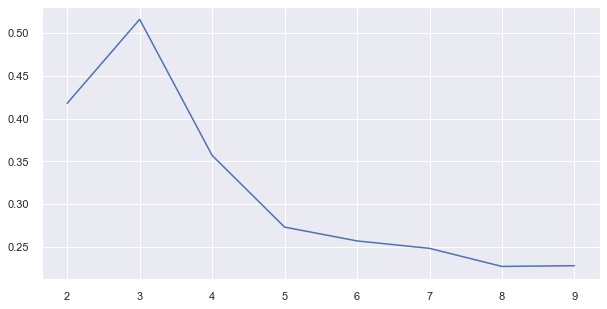

In [248]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    preds = clusterer.fit_predict((df_ss))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(df_ss, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

**Silhouette Scores for Hierarchical Clustering, Distance=Euclidean, Linkage=Average**

For n_clusters = 2, silhouette score is 0.5690653901733652)
For n_clusters = 3, silhouette score is 0.5164769161012985)
For n_clusters = 4, silhouette score is 0.47541352027335854)
For n_clusters = 5, silhouette score is 0.4402145951649964)
For n_clusters = 6, silhouette score is 0.4191811788239719)
For n_clusters = 7, silhouette score is 0.3457105302098707)
For n_clusters = 8, silhouette score is 0.3436755082302095)
For n_clusters = 9, silhouette score is 0.3456792514385861)


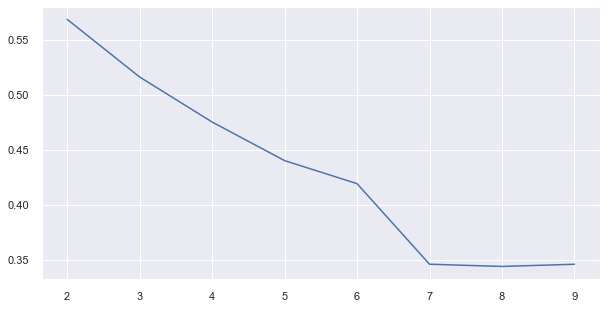

In [249]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity="euclidean", linkage="average")
    preds = clusterer.fit_predict((df_ss))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(df_ss, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

**Silhouette Scores for Hierarchical Clustering, Distance=Euclidean, Linkage=Ward**

For n_clusters = 2, silhouette score is 0.41728405558680587)
For n_clusters = 3, silhouette score is 0.5153242986631665)
For n_clusters = 4, silhouette score is 0.34761868631378606)
For n_clusters = 5, silhouette score is 0.25639140105979114)
For n_clusters = 6, silhouette score is 0.23006871541032045)
For n_clusters = 7, silhouette score is 0.2231958416928567)
For n_clusters = 8, silhouette score is 0.2305240015358501)
For n_clusters = 9, silhouette score is 0.20701877220937753)


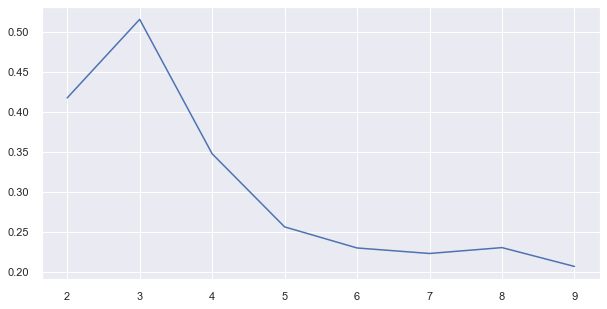

In [250]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity="euclidean", linkage="ward")
    preds = clusterer.fit_predict((df_ss))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(df_ss, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

**Observations**
* When number of clusters = 3, the silhouette scores for each method are the same of very similar: K-means = 0.516, HC_Ave = 0.516, HC_Ward = 0.515. This makes sense, we saw that the clusters were exactly the same for K-means and HC when number of cluster = 3.
* The silhouette vs. number of clusters curves for K-Means and HC_Ward are very similar, the difference in scores is sometimes down to the 3rd decimal place. This indicates that, if we had produced 3 clusters using Hierarchical clustering using Ward, we would have produced somewhat similar clusters.
* The silhouette vs. number of clusters curves for the Ward Method indicates that the highest silhouette score is achieved when number of clusters = 3. The reason that we chose 5 in our case was because, we already had 2 other methods that had produced 3 clusters (both were exactly the same) and there was little point in generating 3 clusters again.

#### How many observations are there in the similar clusters of both algorithms?
Again, when we produced 3 clusters using k-means and hierarchical clustering, the output clusters were exactly the same. We added descriptive labels to the clusters based on the credit limit. The clusters are:
"The High Credit Limit Customer": Number of points = 50 (8% of customers)
"The Average Customer": Number of points = 378 (58% of customers)
"The Low Credit Limit Customer": Number of points = 221 (34% of customers)

For variety we ran hierarchical clustering using Ward Method to produce 5 clusters. This method broke "The Average Customer" and "The Low Credit Limit Customer" clusters into two, mainly based on the number of times the customers had contacted the bank. The clusters were: 
"The High Credit Limit Customer": Number of points = 50 (8% of customers)
"The Average Customer - Low Contact Version": Number of points = 182 (28% of customers)
"The Average Customer - High Contact Version": Number of points = 195 (30% of customers)
"The Low Credit Limit Customer - Low Contact Version": Number of points = 120 (18% of customers)
"The Low Credit Limit Customer - High Contact Version": Number of points = 102 (16% of customers)

So the Ward Method n=5 split our Average and Low Credit Limit Customers into 2 subcategories each, with about even numbers of customers in the subcategories.

#### How many clusters are obtained as the appropriate number of clusters from both algorithms?
For k-means there is an obvious peak in the silhouette scores when k=3. For hierarchical clustering 